# Imports and logs

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision import transforms, models

from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate

import copy
from torch.optim.lr_scheduler import OneCycleLR

from collections import defaultdict

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [3]:
def format_confusion_matrix(cm):
    """Returns a string of a nicely formatted confusion matrix with indices and highlighted diagonal."""
    headers = [""] + [f"Pred {i}" for i in range(len(cm[0]))]
    table = []

    for i, row in enumerate(cm):
        formatted_row = []
        for j, val in enumerate(row):
            if i == j:
                formatted_row.append(f"*{val}*")  # Highlight diagonal
            else:
                formatted_row.append(str(val))
        table.append([f"True {i}"] + formatted_row)

    return tabulate(table, headers=headers, tablefmt="grid")

In [4]:
all_logs = []

def log_and_store(*msgs, table_format=False, is_confmat=False):
    """
    Logs plain messages or pretty-prints confusion matrices or tables.
    """
    if is_confmat and len(msgs) == 1 and isinstance(msgs[0], list):
        msg = format_confusion_matrix(msgs[0])
    elif table_format and len(msgs) == 1 and isinstance(msgs[0], list):
        msg = tabulate(msgs[0], tablefmt="grid")
    else:
        msg = " ".join(str(m) for m in msgs)

    print(msg)
    all_logs.append(msg)

def get_logs():
    """
    Returnerar en lista med alla loggade meddelanden.
    """
    return all_logs

def clear_logs():
    """
    Tömmer loggen.
    """
    all_logs.clear()

def save_logs_to_file(filename):
    """
    Sparar loggade meddelanden till en fil.
    """
    with open(filename, 'w') as f:
        for log in all_logs:
            f.write(log + '\n')

# Training Pipeline



In [5]:
# Configuration
DATA_DIR = "../data-pools/data-consistence"  # Update this path
IMG_SIZE = 224
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
NUM_CLASSES = 0


In [6]:
class StoolDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}
        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                self.class_to_idx[class_name] = idx
                for fname in os.listdir(class_path):
                    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((os.path.join(class_path, fname), idx))
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [7]:
# Stronger and more varied augmentations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),  # random crop + resize
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
    transforms.RandomApply([transforms.Lambda(lambda img: img.filter(ImageFilter.FIND_EDGES))], p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Focal Loss Implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
        
    def __name__(self):
        return "FocalLoss"

In [9]:
def create_model(backbone, num_classes=NUM_CLASSES, freeze_until_layer=None):
    if backbone == 'mobilenet_v3_small':
        model = models.mobilenet_v3_small(pretrained=True)
        # freeze layers
        if freeze_until_layer:
            for name, param in model.features.named_parameters():
                param.requires_grad = False
                if freeze_until_layer in name:
                    break

        # Replace final classifier
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)

    elif backbone == 'mobilenet_v3_large':
        model = models.mobilenet_v3_large(pretrained=True)
        if freeze_until_layer:
            for name, param in model.features.named_parameters():
                param.requires_grad = False
                if freeze_until_layer in name:
                    break

        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)

    elif backbone == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        if freeze_until_layer:
            for name, param in model.features.named_parameters():
                param.requires_grad = False
                if freeze_until_layer in name:
                    break

        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)

    elif backbone == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        if freeze_until_layer:
            for name, param in model.features.named_parameters():
                param.requires_grad = False
                if freeze_until_layer in name:
                    break

        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)

    elif backbone == 'efficientnet_b3':
        model = models.efficientnet_b3(pretrained=True)
        if freeze_until_layer:
            for name, param in model.features.named_parameters():
                param.requires_grad = False
                if freeze_until_layer in name:
                    break

        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)

    else:
        raise ValueError('Invalid backbone')

    return model.to(DEVICE)

In [10]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return None, None, all_preds, all_labels


In [11]:
def train_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, fold_idx, use_best_loss):

    #patience = 3
    #counter = 0
    #lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3) # for accuracy
    #lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3) # for loss

    best_acc     = 0.0
    best_loss    = float('inf')
    best_weights = copy.deepcopy(model.state_dict())

    # ── One‐Cycle LR schedule ──────────────────────────────────────────────────
    scheduler = OneCycleLR(
        optimizer,
        max_lr=optimizer.param_groups[0]['lr'] * 10,  # e.g. 10× your base LR
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
    )

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0


        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0) 
            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)

            scheduler.step()


        epoch_loss = running_loss / total
        epoch_acc = running_corrects / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss_epoch = val_loss / val_total
        val_acc_epoch = val_corrects / val_total
        
        # keep snapshot of best‐ever validation loss (for final restore)
        if use_best_loss:
            if val_loss_epoch < best_loss:
                best_loss    = val_loss_epoch
                best_acc     = val_acc_epoch
                best_weights = copy.deepcopy(model.state_dict())
        else:
            if val_acc_epoch > best_acc:
                best_loss = val_loss_epoch
                print(f"New best model found with accuracy {val_acc_epoch:.4f} and previous best {best_acc:.4f}")
                best_acc = val_acc_epoch
                best_weights = model.state_dict().copy()
            elif val_acc_epoch == best_acc:
                # If accuracy is the same, prefer lower loss
                if val_loss_epoch < best_loss:
                    best_loss = val_loss_epoch
                    best_weights = model.state_dict().copy()

        print(f"Fold {fold_idx}, Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} - "
              f"Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.4f}")

        # Early stopping
        #if val_acc_epoch > best_acc:
        #    best_acc = val_acc_epoch
        #   best_weights = model.state_dict().copy()
        #   counter = 0
        #else:
        #    counter += 1
        #    if counter >= patience:
        #        print(f"Early stopping at epoch {epoch+1}")
        #       break

    # Load best weights
    model.load_state_dict(best_weights)

    # Final validation metrics
    # _, _, preds, labels = evaluate_model(model, val_loader)
    # log_and_store("\nClassification Report for Fold {}:".format(fold_idx))
    # log_and_store(classification_report(labels, preds, target_names=sorted(os.listdir(data_dir)), digits=4))

    return model, best_acc


In [12]:
# Choose device
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available() 
    else "cpu"
)
print(f"Using device: {device}")

Using device: mps


# Training functions

In [13]:
def run_kfold_training(
    data_dir,
    backbone,
    loss_fn,
    freeze_until_layer=None,
    num_epochs=10,
    lr=1e-4,
    k_folds=3,
    batch_size=32,
    seed=42,
    num_classes=NUM_CLASSES,
    use_best_loss=False, # Use best loss for validation, otherwise use best accuracy
):
    full_dataset = StoolDataset(data_dir, transform=None)
    indices = list(range(len(full_dataset)))

    # Class weights for full dataset (optional, for balance insights)
    all_labels_full = [label for _, label in full_dataset]
    class_counts = np.bincount(all_labels_full)
    class_weights = 1.0 / class_counts
    weights_full = [class_weights[label] for label in all_labels_full]

    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
    fold_models = []
    fold_accuracies = []
    per_fold_recalls = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(indices, all_labels_full), 1):
        print(f"\n======= Fold {fold_idx} =======")

        # Subset + transforms
        train_ds = torch.utils.data.Subset(StoolDataset(data_dir, transform=train_transforms), train_idx)
        val_ds   = torch.utils.data.Subset(StoolDataset(data_dir, transform=val_transforms), val_idx)

        # Weighted sampler
        train_labels_fold = [train_ds.dataset.samples[i][1] for i in train_idx]
        class_sample_count_fold = np.array([train_labels_fold.count(i) for i in range(num_classes)])

        print(f"Class sample counts: {class_sample_count_fold}")
        
        class_weights_fold = 1.0 / class_sample_count_fold
        sample_weights_fold = np.array([class_weights_fold[label] for label in train_labels_fold])
        sample_weights_fold = torch.from_numpy(sample_weights_fold.astype(np.double))
        sampler_fold = WeightedRandomSampler(sample_weights_fold, num_samples=len(sample_weights_fold), replacement=True)

        # DataLoaders
        train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler_fold)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        print(f"Training set length: {len(train_loader.dataset)}")
        print(f"Validation set length: {len(val_loader.dataset)}")

        # Create model
        model = create_model(backbone=backbone,num_classes=num_classes , freeze_until_layer=freeze_until_layer)
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # Train
        best_model, best_acc = train_validate(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, fold_idx, use_best_loss)
        fold_models.append(best_model)
        fold_accuracies.append(best_acc)

        # Evaluate and log
        best_model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                logits = best_model(xb)
                preds = logits.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(yb.numpy())

        cm = confusion_matrix(all_labels, all_preds)
        crpt = classification_report(all_labels, all_preds, digits=4)

        cr_dict = classification_report(all_labels, all_preds, digits=4, output_dict=True)
        recalls = {cls: metrics["recall"] for cls, metrics in cr_dict.items() if cls.isdigit()}
        per_fold_recalls.append(recalls)

        log_and_store(f"\n--- Fold {fold_idx} Confusion Matrix ---")
        log_and_store(cm, is_confmat=True)

        log_and_store(f"\n--- Fold {fold_idx} Classification Report ---")
        log_and_store(crpt)

    log_and_store(["\nFold Models:", [f"Fold {i+1}" for i in range(len(fold_models))]])
    log_and_store(["Fold Accuracies:", fold_accuracies])
    log_and_store(["Mean Accuracy:", np.mean(fold_accuracies)])

    # Aggregate and average recalls
    average_recalls = defaultdict(list)
    for recall_dict in per_fold_recalls:
        for cls, value in recall_dict.items():
            average_recalls[cls].append(value)

    average_recalls = {cls: np.mean(vals) for cls, vals in average_recalls.items()}
    log_and_store(["Average Recalls:", average_recalls])


    return fold_models, fold_accuracies, average_recalls


In [14]:
def train_single_split(
    data_dir,
    model_name,
    loss_fn, 
    freeze_until=None,
    batch_size=32,
    lr=1e-4,
    num_epochs=10,
    val_split=0.2,
    seed=42,
    num_classes=NUM_CLASSES,
):
    print("======= Single Split Training =======")

    # Full dataset
    full_dataset = StoolDataset(data_dir, transform=None)
    indices = list(range(len(full_dataset)))
    all_labels = [label for _, label in full_dataset]

    # Train/val split
    train_idx, val_idx = train_test_split(
        indices, test_size=val_split, random_state=seed, stratify=all_labels
    )

    # Create datasets with transforms
    train_ds = Subset(StoolDataset(data_dir, transform=train_transforms), train_idx)
    val_ds = Subset(StoolDataset(data_dir, transform=val_transforms), val_idx)

    # Weighted sampler for class imbalance
    train_labels = [train_ds.dataset.samples[i][1] for i in train_idx]
    class_sample_counts = np.array([train_labels.count(i) for i in range(num_classes)])

    print(f"Class sample counts: {class_sample_counts}")
    
    class_weights = 1.0 / class_sample_counts
    sample_weights = np.array([class_weights[label] for label in train_labels])
    sample_weights = torch.from_numpy(sample_weights.astype(np.double))
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # Data loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    # Model
    model = create_model(backbone=model_name, freeze_until_layer=freeze_until)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    # Train
    best_model, best_acc = train_validate(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, fold_idx=None, use_best_loss=False)

    # Evaluation
    best_model.eval()
    all_preds, all_labels_eval = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = best_model(xb).argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels_eval.extend(yb.numpy())

    # Confusion matrix and classification report
    cm = confusion_matrix(all_labels_eval, all_preds)
    cr = classification_report(all_labels_eval, all_preds, digits=4)

    log_and_store("--- Confusion Matrix ---")
    log_and_store(cm, is_confmat=True)
    log_and_store("--- Classification Report ---")
    log_and_store(cr)

    return best_model, best_acc

# Some parameters

In [15]:
category_data_dir = "../datasets/data-consistence"
constipation_data_dir = "../datasets/data-constipated"
normal_data_dir = "../datasets/data-normal"
loose_data_dir = "../datasets/data-loose"

smooth = nn.CrossEntropyLoss(label_smoothing=0.1)
focal = FocalLoss(alpha=1, gamma=2)

# Model saving fucntions

In [16]:
class AveragingEnsemble(nn.Module):
    def __init__(self, models, weights=None):
        super().__init__()
        self.models = nn.ModuleList(models)
        if weights is None:
            self.register_buffer("weights", torch.ones(len(models)) / len(models))
        else:
            w = torch.tensor(weights, dtype=torch.float32)
            self.register_buffer("weights", w / w.sum())

    def forward(self, x):
        outs = [m(x) for m in self.models]                  # list of [B, C]
        stacked = torch.stack(outs, dim=0)                  # [K, B, C]
        weighted = stacked * self.weights.view(-1, 1, 1)    # broadcast weights
        return weighted.sum(dim=0)                          # [B, C]

In [17]:
def save_ensemble_to_onnx(kf_models, accs=None, output_path="ensemble.onnx"):
    """
    Saves the ensemble of models to an ONNX file.
    """
    for m in kf_models:
        m.eval()
        m.to("cpu")
        for p in m.parameters():
            p.requires_grad_(False)

    ensemble = AveragingEnsemble(kf_models, weights=accs)  # or None for equal weights
    ensemble.eval()
    
    dummy = torch.randn(1, 3, 224, 224)  # adapt shape/channels

    torch.onnx.export(
        ensemble,
        dummy,
        output_path,
        opset_version=13,
        input_names=["image"],
        output_names=["logits"],
        dynamic_axes={"image": {0: "batch"}, "logits": {0: "batch"}},
        do_constant_folding=True,
    )

# Accuracy functions

In [18]:
DATA_DIR = "../datasets/data-BSS"

In [19]:
class_folders = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])

# Count images per class
class_counts = {}
for class_name in class_folders:
    class_path = os.path.join(DATA_DIR, class_name)
    # Count only files (ignore hidden/system files)
    files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    class_counts[class_name] = len(files)

# Print class counts
print("Class counts:")
type_counts = {}
type = 1
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")
    type_counts[type] = count
    type += 1

print(type_counts)


Class counts:
type-1: 65 images
type-2: 92 images
type-3: 323 images
type-4: 326 images
type-5: 39 images
type-6: 42 images
type-7: 84 images
{1: 65, 2: 92, 3: 323, 4: 326, 5: 39, 6: 42, 7: 84}


In [20]:
def compute_hierarchical_accuracy(
    consistency_recalls: dict,
    subtype_accuracies: dict,
    type_counts: dict = type_counts
) -> float:
    """
    Computes the overall hierarchical classification accuracy.

    Args:
        type_counts: dict mapping BSS type (1-7) to number of samples.
                     e.g., {1: 100, 2: 120, 3: 130, ..., 7: 80}
        consistency_recalls: dict mapping consistency class to recall.
                     Keys: 'constipated', 'normal', 'loose'.
                     e.g., {'constipated': 0.80, 'normal': 0.85, 'loose': 0.78}
        subtype_accuracies: dict mapping consistency class to the accuracy of the
                            subtype CNN within that class.
                     e.g., {'constipated': 0.72, 'normal': 0.83, 'loose': 0.69}

    Returns:
        float: overall hierarchical accuracy
    """
    # Define consistency groups
    consistency_groups = {
        'constipated': [1, 2],
        'normal': [3, 4, 5],
        'loose': [6, 7]
    }

    total_samples = sum(type_counts.values())
    hierarchical_accuracy = 0.0

    for group, types in consistency_groups.items():
        # Count how many samples are in this group
        group_count = sum(type_counts[t] for t in types)

        # Proportion of the dataset in this consistency group
        P_c = group_count / total_samples

        # Multiply by consistency recall and subtype accuracy
        A_c = consistency_recalls.get(group, 0.0)
        A_s_given_c = subtype_accuracies.get(group, 0.0)

        hierarchical_accuracy += P_c * A_c * A_s_given_c

    return hierarchical_accuracy

# Category Model

In [104]:
!find ../datasets/data-consistence -name ".DS_Store" -type f -delete

163330.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


## Single Split

In [ ]:
best_model, best_acc = train_single_split(
    data_dir=category_data_dir,
    model_name='efficientnet_b0',
    loss_fn=focal, # focal or smooth
    freeze_until=None,  # or 'features.4', None for no freezing. A higher layer means more layers are frozen.
    batch_size=32,
    lr=1e-4,
    num_epochs=20,
    val_split=0.2,
    num_classes=3
)

======= Single Split Training =======
Class sample counts: [128 100 550]


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold None, Epoch 1/20 - Train Loss: 0.4715, Train Acc: 0.4306 - Val Loss: 0.4329, Val Acc: 0.5385
Fold None, Epoch 2/20 - Train Loss: 0.4060, Train Acc: 0.5643 - Val Loss: 0.3614, Val Acc: 0.6359
Fold None, Epoch 3/20 - Train Loss: 0.3573, Train Acc: 0.6221 - Val Loss: 0.3038, Val Acc: 0.7436
Fold None, Epoch 4/20 - Train Loss: 0.3081, Train Acc: 0.7018 - Val Loss: 0.2511, Val Acc: 0.7744
Fold None, Epoch 5/20 - Train Loss: 0.2899, Train Acc: 0.7147 - Val Loss: 0.2146, Val Acc: 0.8000
Fold None, Epoch 6/20 - Train Loss: 0.2411, Train Acc: 0.7468 - Val Loss: 0.1884, Val Acc: 0.8513
Fold None, Epoch 7/20 - Train Loss: 0.2205, Train Acc: 0.7648 - Val Loss: 0.1746, Val Acc: 0.8667
Fold None, Epoch 8/20 - Train Loss: 0.1894, Train Acc: 0.8162 - Val Loss: 0.1606, Val Acc: 0.8410
Fold None, Epoch 9/20 - Train Loss: 0.1920, Train Acc: 0.8111 - Val Loss: 0.1506, Val Acc: 0.8256
Fold None, Epoch 10/20 - Train Loss: 0.1648, Train Acc: 0.8213 - Val Loss: 0.1456, Val Acc: 0.8308
Fold None, Epoch 11

In [ ]:
best_model, best_acc = train_single_split(
    data_dir=category_data_dir,
    model_name='efficientnet_b0',
    loss_fn=smooth, # focal or smooth
    freeze_until=None,  # or 'features.4', None for no freezing. A higher layer means more layers are frozen.
    batch_size=32,
    lr=1e-4,
    num_epochs=20,
    val_split=0.2,
    num_classes=3
)

======= Single Split Training =======
Class sample counts: [128 100 550]


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold None, Epoch 1/20 - Train Loss: 1.0707, Train Acc: 0.4422 - Val Loss: 1.0217, Val Acc: 0.5590
Fold None, Epoch 2/20 - Train Loss: 1.0113, Train Acc: 0.5334 - Val Loss: 0.9877, Val Acc: 0.5026
Fold None, Epoch 3/20 - Train Loss: 0.9315, Train Acc: 0.6272 - Val Loss: 0.8982, Val Acc: 0.6564
Fold None, Epoch 4/20 - Train Loss: 0.8479, Train Acc: 0.6864 - Val Loss: 0.8357, Val Acc: 0.6872
Fold None, Epoch 5/20 - Train Loss: 0.8122, Train Acc: 0.6992 - Val Loss: 0.7616, Val Acc: 0.7487
Fold None, Epoch 6/20 - Train Loss: 0.7581, Train Acc: 0.7314 - Val Loss: 0.7368, Val Acc: 0.7744
Fold None, Epoch 7/20 - Train Loss: 0.7167, Train Acc: 0.7545 - Val Loss: 0.6781, Val Acc: 0.7949
Fold None, Epoch 8/20 - Train Loss: 0.6938, Train Acc: 0.7686 - Val Loss: 0.6585, Val Acc: 0.7949
Fold None, Epoch 9/20 - Train Loss: 0.6546, Train Acc: 0.8021 - Val Loss: 0.6492, Val Acc: 0.7795
Fold None, Epoch 10/20 - Train Loss: 0.6462, Train Acc: 0.7905 - Val Loss: 0.6013, Val Acc: 0.8154
Fold None, Epoch 11

## K-folds

In [ ]:
kf_models_category, accs_category, recalls = run_kfold_training(
    data_dir=category_data_dir,
    backbone='efficientnet_b0',  # or 'mobilenet_v3_small', 'efficientnet_b0', 'efficientnet_b3'
    loss_fn=focal,
    freeze_until_layer=None,  # or 'features.4' for EfficientNet
    num_epochs=20,
    lr=1e-4,
    k_folds=5,
    batch_size=32,
    seed=42,
    num_classes=3,
    use_best_loss=False
)


======= Fold 1 =======
Class sample counts: [128 100 550]


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1, Epoch 1/20 - Train Loss: 0.4679, Train Acc: 0.4267 - Val Loss: 0.4052, Val Acc: 0.5487
Fold 1, Epoch 2/20 - Train Loss: 0.3144, Train Acc: 0.6620 - Val Loss: 0.2260, Val Acc: 0.7744
Fold 1, Epoch 3/20 - Train Loss: 0.1779, Train Acc: 0.8123 - Val Loss: 0.2251, Val Acc: 0.7333
Fold 1, Epoch 4/20 - Train Loss: 0.1653, Train Acc: 0.8329 - Val Loss: 0.2590, Val Acc: 0.7179
Fold 1, Epoch 5/20 - Train Loss: 0.1718, Train Acc: 0.8303 - Val Loss: 0.3171, Val Acc: 0.7128
Fold 1, Epoch 6/20 - Train Loss: 0.1709, Train Acc: 0.8136 - Val Loss: 0.4068, Val Acc: 0.6974
Fold 1, Epoch 7/20 - Train Loss: 0.1353, Train Acc: 0.8393 - Val Loss: 0.3135, Val Acc: 0.7590
Fold 1, Epoch 8/20 - Train Loss: 0.1420, Train Acc: 0.8432 - Val Loss: 0.2431, Val Acc: 0.7744
Fold 1, Epoch 9/20 - Train Loss: 0.1637, Train Acc: 0.8226 - Val Loss: 0.3554, Val Acc: 0.6974
Fold 1, Epoch 10/20 - Train Loss: 0.1282, Train Acc: 0.8702 - Val Loss: 0.4030, Val Acc: 0.6923
Fold 1, Epoch 11/20 - Train Loss: 0.0951, Train A

/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 2, Epoch 1/20 - Train Loss: 0.4643, Train Acc: 0.4537 - Val Loss: 0.3661, Val Acc: 0.5692
Fold 2, Epoch 2/20 - Train Loss: 0.3222, Train Acc: 0.6594 - Val Loss: 0.2388, Val Acc: 0.7590
Fold 2, Epoch 3/20 - Train Loss: 0.2079, Train Acc: 0.7648 - Val Loss: 0.2288, Val Acc: 0.7744
Fold 2, Epoch 4/20 - Train Loss: 0.1524, Train Acc: 0.8393 - Val Loss: 0.3820, Val Acc: 0.6359
Fold 2, Epoch 5/20 - Train Loss: 0.1799, Train Acc: 0.7918 - Val Loss: 0.2771, Val Acc: 0.7282
Fold 2, Epoch 6/20 - Train Loss: 0.1860, Train Acc: 0.8175 - Val Loss: 0.2993, Val Acc: 0.8000
Fold 2, Epoch 7/20 - Train Loss: 0.1683, Train Acc: 0.8111 - Val Loss: 0.3292, Val Acc: 0.7641
Fold 2, Epoch 8/20 - Train Loss: 0.1422, Train Acc: 0.8329 - Val Loss: 0.3661, Val Acc: 0.7744
Fold 2, Epoch 9/20 - Train Loss: 0.1112, Train Acc: 0.8663 - Val Loss: 0.2956, Val Acc: 0.7744
Fold 2, Epoch 10/20 - Train Loss: 0.1075, Train Acc: 0.8817 - Val Loss: 0.3109, Val Acc: 0.7795
Fold 2, Epoch 11/20 - Train Loss: 0.0984, Train A

/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 3, Epoch 1/20 - Train Loss: 0.4815, Train Acc: 0.4139 - Val Loss: 0.3795, Val Acc: 0.6154
Fold 3, Epoch 2/20 - Train Loss: 0.3385, Train Acc: 0.6465 - Val Loss: 0.2247, Val Acc: 0.7641
Fold 3, Epoch 3/20 - Train Loss: 0.2108, Train Acc: 0.7918 - Val Loss: 0.2213, Val Acc: 0.7026
Fold 3, Epoch 4/20 - Train Loss: 0.1966, Train Acc: 0.7776 - Val Loss: 0.1839, Val Acc: 0.7744
Fold 3, Epoch 5/20 - Train Loss: 0.2034, Train Acc: 0.7931 - Val Loss: 0.2138, Val Acc: 0.7846
Fold 3, Epoch 6/20 - Train Loss: 0.1866, Train Acc: 0.8085 - Val Loss: 0.2593, Val Acc: 0.7128
Fold 3, Epoch 7/20 - Train Loss: 0.1602, Train Acc: 0.8278 - Val Loss: 0.3112, Val Acc: 0.6974
Fold 3, Epoch 8/20 - Train Loss: 0.1276, Train Acc: 0.8470 - Val Loss: 0.1995, Val Acc: 0.8359
Fold 3, Epoch 9/20 - Train Loss: 0.1189, Train Acc: 0.8792 - Val Loss: 0.2026, Val Acc: 0.7795
Fold 3, Epoch 10/20 - Train Loss: 0.1097, Train Acc: 0.8702 - Val Loss: 0.1929, Val Acc: 0.8103
Fold 3, Epoch 11/20 - Train Loss: 0.0985, Train A

/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 4, Epoch 1/20 - Train Loss: 0.4760, Train Acc: 0.4069 - Val Loss: 0.3706, Val Acc: 0.6392
Fold 4, Epoch 2/20 - Train Loss: 0.3372, Train Acc: 0.6444 - Val Loss: 0.2707, Val Acc: 0.7113
Fold 4, Epoch 3/20 - Train Loss: 0.2162, Train Acc: 0.7677 - Val Loss: 0.2504, Val Acc: 0.7526
Fold 4, Epoch 4/20 - Train Loss: 0.1541, Train Acc: 0.8254 - Val Loss: 0.2585, Val Acc: 0.7474
Fold 4, Epoch 5/20 - Train Loss: 0.1719, Train Acc: 0.8087 - Val Loss: 0.5628, Val Acc: 0.4588
Fold 4, Epoch 6/20 - Train Loss: 0.1841, Train Acc: 0.8113 - Val Loss: 0.2928, Val Acc: 0.7113
Fold 4, Epoch 7/20 - Train Loss: 0.2024, Train Acc: 0.7856 - Val Loss: 0.2548, Val Acc: 0.7835
Fold 4, Epoch 8/20 - Train Loss: 0.1740, Train Acc: 0.8216 - Val Loss: 0.2612, Val Acc: 0.7423
Fold 4, Epoch 9/20 - Train Loss: 0.1315, Train Acc: 0.8498 - Val Loss: 0.2299, Val Acc: 0.7577
Fold 4, Epoch 10/20 - Train Loss: 0.1067, Train Acc: 0.8755 - Val Loss: 0.2840, Val Acc: 0.7629
Fold 4, Epoch 11/20 - Train Loss: 0.1099, Train A

/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 5, Epoch 1/20 - Train Loss: 0.4830, Train Acc: 0.4069 - Val Loss: 0.3873, Val Acc: 0.6546
Fold 5, Epoch 2/20 - Train Loss: 0.3267, Train Acc: 0.6816 - Val Loss: 0.2515, Val Acc: 0.6959
Fold 5, Epoch 3/20 - Train Loss: 0.1943, Train Acc: 0.7831 - Val Loss: 0.2873, Val Acc: 0.6443
Fold 5, Epoch 4/20 - Train Loss: 0.1611, Train Acc: 0.8203 - Val Loss: 0.2558, Val Acc: 0.7371
Fold 5, Epoch 5/20 - Train Loss: 0.1719, Train Acc: 0.7985 - Val Loss: 0.5865, Val Acc: 0.6031
Fold 5, Epoch 6/20 - Train Loss: 0.2009, Train Acc: 0.7869 - Val Loss: 0.2816, Val Acc: 0.8041
Fold 5, Epoch 7/20 - Train Loss: 0.1850, Train Acc: 0.8074 - Val Loss: 0.5131, Val Acc: 0.5619
Fold 5, Epoch 8/20 - Train Loss: 0.1521, Train Acc: 0.8383 - Val Loss: 0.5063, Val Acc: 0.5567
Fold 5, Epoch 9/20 - Train Loss: 0.1406, Train Acc: 0.8549 - Val Loss: 0.2016, Val Acc: 0.7680
Fold 5, Epoch 10/20 - Train Loss: 0.0966, Train Acc: 0.8742 - Val Loss: 0.3757, Val Acc: 0.6649
Fold 5, Epoch 11/20 - Train Loss: 0.0906, Train A

A = [[ 19   4   9]
 [  1  19   5]
 [ 25   8 105]]

B = [[ 13   3  16]
 [  1  19   5]
 [ 17   2 119]]

C = [[ 24   0   8]
 [  1  22   2]
 [ 19   1 118]]

D = [[ 19   1  12]
 [  1  20   4]
 [ 13   4 120]]

E = [[ 19   2  11]
 [  2  17   6]
 [ 15   1 121]]

In [36]:
kf_models_category, accs_category, recalls = run_kfold_training(
    data_dir=category_data_dir,
    backbone='efficientnet_b0',  # or 'mobilenet_v3_small', 'efficientnet_b0', 'efficientnet_b3'
    loss_fn=focal,
    freeze_until_layer=None,  # or 'features.4' for EfficientNet
    num_epochs=20,
    lr=1e-4,
    k_folds=5,
    batch_size=32,
    seed=42,
    num_classes=3,
    use_best_loss=False
)


======= Fold 1 =======
Class sample counts: [128 100 550]
Training set length: 778
Validation set length: 195


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [31]:
# used best acc
consistency_recalls = {
    'constipated': 0.5875,
    'normal': 0.8474769914312917,
    'loose': 0.776
}


subtype_accuracies = {}

## Save Model

In [ ]:
save_ensemble_to_onnx(kf_models_category, accs_category, output_path="category_classification.onnx")

# Constipated Model

In [124]:
!find ../datasets/data-constipated -name ".DS_Store" -type f -delete

167570.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


## Single Split

In [171]:
best_model, best_acc = train_single_split(
    data_dir=constipation_data_dir,
    model_name='efficientnet_b0',
    loss_fn=smooth, # 'focal' or 'smooth'
    freeze_until=None,  # or 'features.4', None for no freezing. A higher layer means more layers are frozen.
    batch_size=32,
    lr=1e-4,
    num_epochs=30,
    val_split=0.2,
    num_classes=2
)

======= Single Split Training =======
Class sample counts: [52 73]


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.3125 and previous best 0.0000
Fold None, Epoch 1/30 - Train Loss: 1.0573, Train Acc: 0.4720 - Val Loss: 1.1171, Val Acc: 0.3125
New best model found with accuracy 0.5312 and previous best 0.3125
Fold None, Epoch 2/30 - Train Loss: 1.0175, Train Acc: 0.5440 - Val Loss: 1.0229, Val Acc: 0.5312
New best model found with accuracy 0.7188 and previous best 0.5312
Fold None, Epoch 3/30 - Train Loss: 0.9448, Train Acc: 0.6960 - Val Loss: 0.8822, Val Acc: 0.7188
New best model found with accuracy 0.7500 and previous best 0.7188
Fold None, Epoch 4/30 - Train Loss: 0.7786, Train Acc: 0.8640 - Val Loss: 0.7204, Val Acc: 0.7500
Fold None, Epoch 5/30 - Train Loss: 0.6743, Train Acc: 0.8160 - Val Loss: 0.6972, Val Acc: 0.7500
Fold None, Epoch 6/30 - Train Loss: 0.6472, Train Acc: 0.7760 - Val Loss: 0.8057, Val Acc: 0.7500
Fold None, Epoch 7/30 - Train Loss: 0.4955, Train Acc: 0.9120 - Val Loss: 0.8904, Val Acc: 0.7500
Fold None, Epoch 8/30 - Train Loss: 0.4402, Tr

In [172]:
best_model, best_acc = train_single_split(
    data_dir=constipation_data_dir,
    model_name='efficientnet_b0',
    loss_fn=focal, # 'focal' or 'smooth'
    freeze_until=None,  # or 'features.4', None for no freezing. A higher layer means more layers are frozen.
    batch_size=32,
    lr=1e-4,
    num_epochs=30,
    val_split=0.2,
    num_classes=2
)

======= Single Split Training =======
Class sample counts: [52 73]


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.1875 and previous best 0.0000
Fold None, Epoch 1/30 - Train Loss: 0.5153, Train Acc: 0.2960 - Val Loss: 0.6106, Val Acc: 0.1875
New best model found with accuracy 0.3438 and previous best 0.1875
Fold None, Epoch 2/30 - Train Loss: 0.4910, Train Acc: 0.3600 - Val Loss: 0.5154, Val Acc: 0.3438
New best model found with accuracy 0.6250 and previous best 0.3438
Fold None, Epoch 3/30 - Train Loss: 0.3732, Train Acc: 0.6720 - Val Loss: 0.3597, Val Acc: 0.6250
New best model found with accuracy 0.6875 and previous best 0.6250
Fold None, Epoch 4/30 - Train Loss: 0.2991, Train Acc: 0.6880 - Val Loss: 0.2326, Val Acc: 0.6875
New best model found with accuracy 0.7500 and previous best 0.6875
Fold None, Epoch 5/30 - Train Loss: 0.1842, Train Acc: 0.8160 - Val Loss: 0.1801, Val Acc: 0.7500
New best model found with accuracy 0.7812 and previous best 0.7500
Fold None, Epoch 6/30 - Train Loss: 0.1199, Train Acc: 0.8960 - Val Loss: 0.1872, Val Acc: 0.7812
Fold None,

In [ ]:
best_model, best_acc = train_single_split(
    data_dir=constipation_data_dir,
    model_name='efficientnet_b0',
    loss_fn=smooth, # 'focal' or 'smooth'
    freeze_until='features.1',  # or 'features.4', None for no freezing. A higher layer means more layers are frozen.
    batch_size=32,
    lr=1e-4,
    num_epochs=30,
    val_split=0.2,
    num_classes=2
)

======= Single Split Training =======
Class sample counts: [52 73]


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold None, Epoch 1/30 - Train Loss: 1.1294, Train Acc: 0.3280 - Val Loss: 1.1471, Val Acc: 0.2812
Fold None, Epoch 2/30 - Train Loss: 1.1228, Train Acc: 0.3440 - Val Loss: 1.1464, Val Acc: 0.2812
Fold None, Epoch 3/30 - Train Loss: 1.0767, Train Acc: 0.4000 - Val Loss: 1.1242, Val Acc: 0.3125
Fold None, Epoch 4/30 - Train Loss: 1.0695, Train Acc: 0.4880 - Val Loss: 1.0984, Val Acc: 0.4062
Fold None, Epoch 5/30 - Train Loss: 1.0998, Train Acc: 0.3840 - Val Loss: 1.0709, Val Acc: 0.4375
Fold None, Epoch 6/30 - Train Loss: 1.0561, Train Acc: 0.4080 - Val Loss: 1.0399, Val Acc: 0.3750
Fold None, Epoch 7/30 - Train Loss: 1.0257, Train Acc: 0.4640 - Val Loss: 1.0153, Val Acc: 0.4688
Fold None, Epoch 8/30 - Train Loss: 1.0014, Train Acc: 0.4880 - Val Loss: 0.9879, Val Acc: 0.4688
Fold None, Epoch 9/30 - Train Loss: 0.9691, Train Acc: 0.4640 - Val Loss: 0.9614, Val Acc: 0.5625
Fold None, Epoch 10/30 - Train Loss: 0.9413, Train Acc: 0.5040 - Val Loss: 0.9337, Val Acc: 0.5938
Fold None, Epoch 11

## K-fold

In [173]:
kf_models_constipated, accs_constipated, recalls = run_kfold_training(
    data_dir=constipation_data_dir,
    backbone='efficientnet_b0',  # or 'mobilenet_v3_small', 'efficientnet_b0', 'efficientnet_b3'
    loss_fn=smooth,
    freeze_until_layer=None,  # or 'features.4' for EfficientNet
    num_epochs=30,
    lr=1e-4,
    k_folds=5,
    batch_size=32,
    seed=42,
    num_classes=2,
    use_best_loss=False
)


======= Fold 1 =======
Class sample counts: [52 73]


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.4062 and previous best 0.0000
Fold 1, Epoch 1/30 - Train Loss: 1.0637, Train Acc: 0.4640 - Val Loss: 1.0852, Val Acc: 0.4062
New best model found with accuracy 0.5625 and previous best 0.4062
Fold 1, Epoch 2/30 - Train Loss: 1.0212, Train Acc: 0.4480 - Val Loss: 1.0054, Val Acc: 0.5625
New best model found with accuracy 0.6562 and previous best 0.5625
Fold 1, Epoch 3/30 - Train Loss: 0.9506, Train Acc: 0.6400 - Val Loss: 0.8940, Val Acc: 0.6562
New best model found with accuracy 0.6875 and previous best 0.6562
Fold 1, Epoch 4/30 - Train Loss: 0.8666, Train Acc: 0.6720 - Val Loss: 0.7944, Val Acc: 0.6875
New best model found with accuracy 0.7188 and previous best 0.6875
Fold 1, Epoch 5/30 - Train Loss: 0.7391, Train Acc: 0.7280 - Val Loss: 0.7454, Val Acc: 0.7188
New best model found with accuracy 0.7500 and previous best 0.7188
Fold 1, Epoch 6/30 - Train Loss: 0.6153, Train Acc: 0.8720 - Val Loss: 0.7544, Val Acc: 0.7500
Fold 1, Epoch 7/30 - Train L

/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.5938 and previous best 0.0000
Fold 2, Epoch 1/30 - Train Loss: 1.1484, Train Acc: 0.2160 - Val Loss: 1.0275, Val Acc: 0.5938
New best model found with accuracy 0.7500 and previous best 0.5938
Fold 2, Epoch 2/30 - Train Loss: 1.0911, Train Acc: 0.4560 - Val Loss: 0.9640, Val Acc: 0.7500
Fold 2, Epoch 3/30 - Train Loss: 0.9903, Train Acc: 0.6240 - Val Loss: 0.8674, Val Acc: 0.7500
Fold 2, Epoch 4/30 - Train Loss: 0.8918, Train Acc: 0.7040 - Val Loss: 0.7389, Val Acc: 0.7500
New best model found with accuracy 0.7812 and previous best 0.7500
Fold 2, Epoch 5/30 - Train Loss: 0.7392, Train Acc: 0.8320 - Val Loss: 0.6894, Val Acc: 0.7812
Fold 2, Epoch 6/30 - Train Loss: 0.5984, Train Acc: 0.8480 - Val Loss: 0.8133, Val Acc: 0.7188
Fold 2, Epoch 7/30 - Train Loss: 0.4714, Train Acc: 0.9120 - Val Loss: 0.8854, Val Acc: 0.6562
Fold 2, Epoch 8/30 - Train Loss: 0.4726, Train Acc: 0.8880 - Val Loss: 0.8381, Val Acc: 0.7500
Fold 2, Epoch 9/30 - Train Loss: 0.5044

/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.3226 and previous best 0.0000
Fold 3, Epoch 1/30 - Train Loss: 1.1307, Train Acc: 0.2778 - Val Loss: 1.1228, Val Acc: 0.3226
New best model found with accuracy 0.4516 and previous best 0.3226
Fold 3, Epoch 2/30 - Train Loss: 1.0725, Train Acc: 0.4286 - Val Loss: 1.0530, Val Acc: 0.4516
New best model found with accuracy 0.4839 and previous best 0.4516
Fold 3, Epoch 3/30 - Train Loss: 0.9914, Train Acc: 0.5873 - Val Loss: 0.9679, Val Acc: 0.4839
New best model found with accuracy 0.5806 and previous best 0.4839
Fold 3, Epoch 4/30 - Train Loss: 0.8410, Train Acc: 0.7778 - Val Loss: 0.8847, Val Acc: 0.5806
Fold 3, Epoch 5/30 - Train Loss: 0.7218, Train Acc: 0.8095 - Val Loss: 0.8575, Val Acc: 0.5484
New best model found with accuracy 0.6452 and previous best 0.5806
Fold 3, Epoch 6/30 - Train Loss: 0.5658, Train Acc: 0.8571 - Val Loss: 0.8334, Val Acc: 0.6452
Fold 3, Epoch 7/30 - Train Loss: 0.4978, Train Acc: 0.8889 - Val Loss: 1.1642, Val Acc: 0.6129


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.2258 and previous best 0.0000
Fold 4, Epoch 1/30 - Train Loss: 1.1536, Train Acc: 0.2619 - Val Loss: 1.1726, Val Acc: 0.2258
New best model found with accuracy 0.4194 and previous best 0.2258
Fold 4, Epoch 2/30 - Train Loss: 1.1094, Train Acc: 0.3095 - Val Loss: 1.0959, Val Acc: 0.4194
New best model found with accuracy 0.5806 and previous best 0.4194
Fold 4, Epoch 3/30 - Train Loss: 1.0251, Train Acc: 0.5317 - Val Loss: 0.9807, Val Acc: 0.5806
New best model found with accuracy 0.6129 and previous best 0.5806
Fold 4, Epoch 4/30 - Train Loss: 0.8788, Train Acc: 0.7381 - Val Loss: 0.8657, Val Acc: 0.6129
Fold 4, Epoch 5/30 - Train Loss: 0.7206, Train Acc: 0.8254 - Val Loss: 0.8081, Val Acc: 0.6129
New best model found with accuracy 0.6452 and previous best 0.6129
Fold 4, Epoch 6/30 - Train Loss: 0.5865, Train Acc: 0.8730 - Val Loss: 1.0193, Val Acc: 0.6452
Fold 4, Epoch 7/30 - Train Loss: 0.5217, Train Acc: 0.8730 - Val Loss: 1.3451, Val Acc: 0.6129


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.2903 and previous best 0.0000
Fold 5, Epoch 1/30 - Train Loss: 1.0699, Train Acc: 0.4762 - Val Loss: 1.1188, Val Acc: 0.2903
New best model found with accuracy 0.5161 and previous best 0.2903
Fold 5, Epoch 2/30 - Train Loss: 1.0763, Train Acc: 0.4444 - Val Loss: 0.9999, Val Acc: 0.5161
New best model found with accuracy 0.7419 and previous best 0.5161
Fold 5, Epoch 3/30 - Train Loss: 0.9710, Train Acc: 0.6032 - Val Loss: 0.8553, Val Acc: 0.7419
Fold 5, Epoch 4/30 - Train Loss: 0.8524, Train Acc: 0.7619 - Val Loss: 0.7145, Val Acc: 0.7419
Fold 5, Epoch 5/30 - Train Loss: 0.7256, Train Acc: 0.8175 - Val Loss: 0.6651, Val Acc: 0.7097
New best model found with accuracy 0.8065 and previous best 0.7419
Fold 5, Epoch 6/30 - Train Loss: 0.5852, Train Acc: 0.8571 - Val Loss: 0.6786, Val Acc: 0.8065
Fold 5, Epoch 7/30 - Train Loss: 0.4982, Train Acc: 0.8810 - Val Loss: 0.6624, Val Acc: 0.7419
Fold 5, Epoch 8/30 - Train Loss: 0.4614, Train Acc: 0.9048 - Val Lo

In [32]:
subtype_accuracies['constipated'] = 0.7830645161290324 #np.mean(accs)

## Save Models

In [ ]:
save_ensemble_to_onnx(kf_models_constipated, accs_constipated, output_path="constipated_subtype_classification.onnx")

# Normal Model

In [178]:
!find ../datasets/data-normal -name ".DS_Store" -type f -delete

445028.33s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


## Single Split

In [ ]:
# I ran without type-5 to see
best_model, best_acc = train_single_split(
    data_dir=normal_data_dir,
    model_name='efficientnet_b0',
    loss_fn=smooth, # 'focal' or 'smooth'
    freeze_until=None,  # or 'features.4', None for no freezing. A higher layer means more layers are frozen.
    batch_size=32,
    lr=1e-4,
    num_epochs=20,
    val_split=0.2,
    num_classes=2
)

======= Single Split Training =======
Class sample counts: [258 261]


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.5385 and previous best 0.0000
Fold None, Epoch 1/20 - Train Loss: 1.0728, Train Acc: 0.4123 - Val Loss: 0.9521, Val Acc: 0.5385
New best model found with accuracy 0.6615 and previous best 0.5385
Fold None, Epoch 2/20 - Train Loss: 0.9086, Train Acc: 0.6089 - Val Loss: 0.7867, Val Acc: 0.6615
New best model found with accuracy 0.6923 and previous best 0.6615
Fold None, Epoch 3/20 - Train Loss: 0.7268, Train Acc: 0.7264 - Val Loss: 0.7669, Val Acc: 0.6923
Fold None, Epoch 4/20 - Train Loss: 0.7016, Train Acc: 0.7380 - Val Loss: 0.8809, Val Acc: 0.6462
Fold None, Epoch 5/20 - Train Loss: 0.6598, Train Acc: 0.7630 - Val Loss: 0.9528, Val Acc: 0.6692
Fold None, Epoch 6/20 - Train Loss: 0.6567, Train Acc: 0.7900 - Val Loss: 0.9076, Val Acc: 0.6077
Fold None, Epoch 7/20 - Train Loss: 0.5742, Train Acc: 0.8324 - Val Loss: 0.8591, Val Acc: 0.6846
Fold None, Epoch 8/20 - Train Loss: 0.5532, Train Acc: 0.8651 - Val Loss: 0.8900, Val Acc: 0.6308
Fold None, Epoc

In [ ]:
best_model, best_acc = train_single_split(
    data_dir=normal_data_dir,
    model_name='efficientnet_b0',
    loss_fn=smooth, # 'focal' or 'smooth'
    freeze_until=None,  # or 'features.4', None for no freezing. A higher layer means more layers are frozen.
    batch_size=32,
    lr=1e-4,
    num_epochs=20,
    val_split=0.2,
    num_classes=3
)

======= Single Split Training =======
Class sample counts: [258 261  31]


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.4493 and previous best 0.0000
Fold None, Epoch 1/20 - Train Loss: 1.0844, Train Acc: 0.4018 - Val Loss: 1.0585, Val Acc: 0.4493
New best model found with accuracy 0.5580 and previous best 0.4493
Fold None, Epoch 2/20 - Train Loss: 0.9288, Train Acc: 0.5636 - Val Loss: 0.9658, Val Acc: 0.5580
New best model found with accuracy 0.6159 and previous best 0.5580
Fold None, Epoch 3/20 - Train Loss: 0.7877, Train Acc: 0.6891 - Val Loss: 0.8606, Val Acc: 0.6159
Fold None, Epoch 4/20 - Train Loss: 0.6641, Train Acc: 0.7600 - Val Loss: 1.0355, Val Acc: 0.5797
Fold None, Epoch 5/20 - Train Loss: 0.6499, Train Acc: 0.7982 - Val Loss: 0.9877, Val Acc: 0.5507
New best model found with accuracy 0.6304 and previous best 0.6159
Fold None, Epoch 6/20 - Train Loss: 0.6598, Train Acc: 0.7727 - Val Loss: 0.9375, Val Acc: 0.6304
Fold None, Epoch 7/20 - Train Loss: 0.6244, Train Acc: 0.8164 - Val Loss: 0.9806, Val Acc: 0.5725
Fold None, Epoch 8/20 - Train Loss: 0.6067, Tr

In [175]:
best_model, best_acc = train_single_split(
    data_dir=normal_data_dir,
    model_name='efficientnet_b0',
    loss_fn=focal, # 'focal' or 'smooth'
    freeze_until=None,  # or 'features.4', None for no freezing. A higher layer means more layers are frozen.
    batch_size=32,
    lr=1e-4,
    num_epochs=20,
    val_split=0.2,
    num_classes=3
)

======= Single Split Training =======
Class sample counts: [258 261  31]


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.4783 and previous best 0.0000
Fold None, Epoch 1/20 - Train Loss: 0.4579, Train Acc: 0.4364 - Val Loss: 0.4725, Val Acc: 0.4783
New best model found with accuracy 0.4928 and previous best 0.4783
Fold None, Epoch 2/20 - Train Loss: 0.3513, Train Acc: 0.6273 - Val Loss: 0.3918, Val Acc: 0.4928
New best model found with accuracy 0.6594 and previous best 0.4928
Fold None, Epoch 3/20 - Train Loss: 0.2417, Train Acc: 0.7145 - Val Loss: 0.3200, Val Acc: 0.6594
New best model found with accuracy 0.6812 and previous best 0.6594
Fold None, Epoch 4/20 - Train Loss: 0.1713, Train Acc: 0.8164 - Val Loss: 0.3995, Val Acc: 0.6812
Fold None, Epoch 5/20 - Train Loss: 0.1588, Train Acc: 0.8200 - Val Loss: 0.4523, Val Acc: 0.5797
Fold None, Epoch 6/20 - Train Loss: 0.2062, Train Acc: 0.7400 - Val Loss: 0.3952, Val Acc: 0.6087
Fold None, Epoch 7/20 - Train Loss: 0.1751, Train Acc: 0.7982 - Val Loss: 0.3287, Val Acc: 0.5725
Fold None, Epoch 8/20 - Train Loss: 0.1726, Tr

In [ ]:
best_model, best_acc = train_single_split(
    data_dir=normal_data_dir,
    model_name='efficientnet_b3',
    loss_fn=focal, # 'focal' or 'smooth'
    freeze_until=None,  # or 'features.4', None for no freezing. A higher layer means more layers are frozen.
    batch_size=32,
    lr=1e-4,
    num_epochs=20,
    val_split=0.2,
    num_classes=3
)

======= Single Split Training =======
Class sample counts: [258 261  31]


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold None, Epoch 1/20 - Train Loss: 0.4732, Train Acc: 0.4182 - Val Loss: 0.4787, Val Acc: 0.3696
Fold None, Epoch 2/20 - Train Loss: 0.4216, Train Acc: 0.5273 - Val Loss: 0.4427, Val Acc: 0.4783
Fold None, Epoch 3/20 - Train Loss: 0.3939, Train Acc: 0.5655 - Val Loss: 0.4147, Val Acc: 0.5145
Fold None, Epoch 4/20 - Train Loss: 0.3642, Train Acc: 0.5800 - Val Loss: 0.3953, Val Acc: 0.5362
Fold None, Epoch 5/20 - Train Loss: 0.3246, Train Acc: 0.6291 - Val Loss: 0.3703, Val Acc: 0.5725
Fold None, Epoch 6/20 - Train Loss: 0.3215, Train Acc: 0.6327 - Val Loss: 0.3557, Val Acc: 0.5942
Fold None, Epoch 7/20 - Train Loss: 0.2876, Train Acc: 0.6836 - Val Loss: 0.3328, Val Acc: 0.6304
Fold None, Epoch 8/20 - Train Loss: 0.2635, Train Acc: 0.7327 - Val Loss: 0.3242, Val Acc: 0.6377
Fold None, Epoch 9/20 - Train Loss: 0.2492, Train Acc: 0.7236 - Val Loss: 0.3024, Val Acc: 0.6232
Fold None, Epoch 10/20 - Train Loss: 0.2204, Train Acc: 0.7527 - Val Loss: 0.2899, Val Acc: 0.6522
Fold None, Epoch 11

In [100]:
best_model, best_acc = train_single_split(
    data_dir=normal_data_dir,
    model_name='efficientnet_b3',
    loss_fn=smooth, # 'focal' or 'smooth'
    freeze_until=None,  # or 'features.4', None for no freezing. A higher layer means more layers are frozen.
    batch_size=32,
    lr=1e-4,
    num_epochs=20,
    val_split=0.2,
    num_classes=3
)

======= Single Split Training =======
Class sample counts: [258 261  31]


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold None, Epoch 1/20 - Train Loss: 1.1094, Train Acc: 0.3091 - Val Loss: 1.0993, Val Acc: 0.3261
Fold None, Epoch 2/20 - Train Loss: 1.0634, Train Acc: 0.4345 - Val Loss: 1.0806, Val Acc: 0.3841
Fold None, Epoch 3/20 - Train Loss: 1.0075, Train Acc: 0.5327 - Val Loss: 1.0566, Val Acc: 0.4493
Fold None, Epoch 4/20 - Train Loss: 0.9688, Train Acc: 0.5745 - Val Loss: 1.0312, Val Acc: 0.4928
Fold None, Epoch 5/20 - Train Loss: 0.9227, Train Acc: 0.6036 - Val Loss: 0.9995, Val Acc: 0.5580
Fold None, Epoch 6/20 - Train Loss: 0.8902, Train Acc: 0.6109 - Val Loss: 0.9762, Val Acc: 0.5435
Fold None, Epoch 7/20 - Train Loss: 0.8688, Train Acc: 0.6345 - Val Loss: 0.9711, Val Acc: 0.5652
Fold None, Epoch 8/20 - Train Loss: 0.8179, Train Acc: 0.6836 - Val Loss: 0.9315, Val Acc: 0.6087
Fold None, Epoch 9/20 - Train Loss: 0.8141, Train Acc: 0.6836 - Val Loss: 0.9078, Val Acc: 0.6087
Fold None, Epoch 10/20 - Train Loss: 0.7747, Train Acc: 0.7182 - Val Loss: 0.8816, Val Acc: 0.6087
Fold None, Epoch 11

## K-folds

In [179]:
kf_models_normal, accs_normal, recalls = run_kfold_training(
    data_dir=normal_data_dir,
    backbone='efficientnet_b0',  # or 'mobilenet_v3_small', 'efficientnet_b0', 'efficientnet_b3'
    loss_fn=focal,
    freeze_until_layer=None,  # or 'features.4' for EfficientNet
    num_epochs=24,
    lr=1e-4,
    k_folds=5,
    batch_size=32,
    seed=42,
    num_classes=3,
    use_best_loss=False
)


======= Fold 1 =======
Class sample counts: [258 261  31]


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.4348 and previous best 0.0000
Fold 1, Epoch 1/24 - Train Loss: 0.4741, Train Acc: 0.4109 - Val Loss: 0.4765, Val Acc: 0.4348
New best model found with accuracy 0.5435 and previous best 0.4348
Fold 1, Epoch 2/24 - Train Loss: 0.3944, Train Acc: 0.5073 - Val Loss: 0.3983, Val Acc: 0.5435
New best model found with accuracy 0.6304 and previous best 0.5435
Fold 1, Epoch 3/24 - Train Loss: 0.2815, Train Acc: 0.6891 - Val Loss: 0.3157, Val Acc: 0.6304
Fold 1, Epoch 4/24 - Train Loss: 0.2129, Train Acc: 0.7491 - Val Loss: 0.3109, Val Acc: 0.5725
Fold 1, Epoch 5/24 - Train Loss: 0.1653, Train Acc: 0.7709 - Val Loss: 0.3327, Val Acc: 0.6304
Fold 1, Epoch 6/24 - Train Loss: 0.2038, Train Acc: 0.7364 - Val Loss: 0.4554, Val Acc: 0.6304
Fold 1, Epoch 7/24 - Train Loss: 0.1863, Train Acc: 0.7673 - Val Loss: 0.3962, Val Acc: 0.5942
Fold 1, Epoch 8/24 - Train Loss: 0.2081, Train Acc: 0.7564 - Val Loss: 0.3386, Val Acc: 0.6159
Fold 1, Epoch 9/24 - Train Loss: 0.1460

/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.3768 and previous best 0.0000
Fold 2, Epoch 1/24 - Train Loss: 0.4800, Train Acc: 0.4055 - Val Loss: 0.4739, Val Acc: 0.3768
New best model found with accuracy 0.5217 and previous best 0.3768
Fold 2, Epoch 2/24 - Train Loss: 0.3784, Train Acc: 0.5782 - Val Loss: 0.3806, Val Acc: 0.5217
New best model found with accuracy 0.6232 and previous best 0.5217
Fold 2, Epoch 3/24 - Train Loss: 0.2587, Train Acc: 0.6945 - Val Loss: 0.3052, Val Acc: 0.6232
New best model found with accuracy 0.6594 and previous best 0.6232
Fold 2, Epoch 4/24 - Train Loss: 0.1927, Train Acc: 0.7545 - Val Loss: 0.4000, Val Acc: 0.6594
New best model found with accuracy 0.6884 and previous best 0.6594
Fold 2, Epoch 5/24 - Train Loss: 0.1638, Train Acc: 0.8073 - Val Loss: 0.3592, Val Acc: 0.6884
Fold 2, Epoch 6/24 - Train Loss: 0.1764, Train Acc: 0.7909 - Val Loss: 0.4460, Val Acc: 0.6014
Fold 2, Epoch 7/24 - Train Loss: 0.1727, Train Acc: 0.7891 - Val Loss: 0.4717, Val Acc: 0.6304


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.2754 and previous best 0.0000
Fold 3, Epoch 1/24 - Train Loss: 0.4743, Train Acc: 0.4182 - Val Loss: 0.5540, Val Acc: 0.2754
New best model found with accuracy 0.4783 and previous best 0.2754
Fold 3, Epoch 2/24 - Train Loss: 0.3810, Train Acc: 0.5818 - Val Loss: 0.4245, Val Acc: 0.4783
New best model found with accuracy 0.5652 and previous best 0.4783
Fold 3, Epoch 3/24 - Train Loss: 0.2916, Train Acc: 0.6709 - Val Loss: 0.3576, Val Acc: 0.5652
New best model found with accuracy 0.6449 and previous best 0.5652
Fold 3, Epoch 4/24 - Train Loss: 0.1816, Train Acc: 0.7727 - Val Loss: 0.3315, Val Acc: 0.6449
Fold 3, Epoch 5/24 - Train Loss: 0.1565, Train Acc: 0.7782 - Val Loss: 0.5785, Val Acc: 0.4855
Fold 3, Epoch 6/24 - Train Loss: 0.1976, Train Acc: 0.7345 - Val Loss: 0.3279, Val Acc: 0.5507
Fold 3, Epoch 7/24 - Train Loss: 0.1791, Train Acc: 0.7818 - Val Loss: 0.2830, Val Acc: 0.6304
Fold 3, Epoch 8/24 - Train Loss: 0.1670, Train Acc: 0.8091 - Val Lo

/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.5401 and previous best 0.0000
Fold 4, Epoch 1/24 - Train Loss: 0.4834, Train Acc: 0.4047 - Val Loss: 0.4482, Val Acc: 0.5401
New best model found with accuracy 0.5474 and previous best 0.5401
Fold 4, Epoch 2/24 - Train Loss: 0.3922, Train Acc: 0.5463 - Val Loss: 0.3660, Val Acc: 0.5474
New best model found with accuracy 0.6204 and previous best 0.5474
Fold 4, Epoch 3/24 - Train Loss: 0.2816, Train Acc: 0.6933 - Val Loss: 0.2709, Val Acc: 0.6204
Fold 4, Epoch 4/24 - Train Loss: 0.1800, Train Acc: 0.8058 - Val Loss: 0.2946, Val Acc: 0.5985
Fold 4, Epoch 5/24 - Train Loss: 0.1729, Train Acc: 0.7949 - Val Loss: 0.3091, Val Acc: 0.6058
Fold 4, Epoch 6/24 - Train Loss: 0.1684, Train Acc: 0.7913 - Val Loss: 0.3305, Val Acc: 0.5839
Fold 4, Epoch 7/24 - Train Loss: 0.1971, Train Acc: 0.7695 - Val Loss: 0.4721, Val Acc: 0.5985
Fold 4, Epoch 8/24 - Train Loss: 0.1565, Train Acc: 0.8040 - Val Loss: 0.5611, Val Acc: 0.5547
Fold 4, Epoch 9/24 - Train Loss: 0.2152

/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.4891 and previous best 0.0000
Fold 5, Epoch 1/24 - Train Loss: 0.4767, Train Acc: 0.4229 - Val Loss: 0.4423, Val Acc: 0.4891
New best model found with accuracy 0.5474 and previous best 0.4891
Fold 5, Epoch 2/24 - Train Loss: 0.3955, Train Acc: 0.5662 - Val Loss: 0.3612, Val Acc: 0.5474
New best model found with accuracy 0.6058 and previous best 0.5474
Fold 5, Epoch 3/24 - Train Loss: 0.2882, Train Acc: 0.7042 - Val Loss: 0.2933, Val Acc: 0.6058
New best model found with accuracy 0.6423 and previous best 0.6058
Fold 5, Epoch 4/24 - Train Loss: 0.2011, Train Acc: 0.7477 - Val Loss: 0.2524, Val Acc: 0.6423
Fold 5, Epoch 5/24 - Train Loss: 0.1547, Train Acc: 0.8240 - Val Loss: 0.3429, Val Acc: 0.6277
Fold 5, Epoch 6/24 - Train Loss: 0.1943, Train Acc: 0.7931 - Val Loss: 0.3388, Val Acc: 0.5766
Fold 5, Epoch 7/24 - Train Loss: 0.1952, Train Acc: 0.7858 - Val Loss: 0.4560, Val Acc: 0.6204
Fold 5, Epoch 8/24 - Train Loss: 0.2237, Train Acc: 0.7495 - Val Lo

In [33]:
subtype_accuracies['normal'] = 0.7222997990056067 #np.mean(accs)

## Save Models

In [ ]:
save_ensemble_to_onnx(kf_models_normal, accs_normal, output_path="normal_subtype_classification.onnx")

# Loose Model

In [23]:
!find ../datasets/data-loose -name ".DS_Store" -type f -delete

## Single Split

In [156]:
best_model, best_acc, lrs = train_single_split(
    data_dir=loose_data_dir,
    model_name='efficientnet_b0',
    loss_fn=smooth, # 'focal' or 'smooth'
    freeze_until=None,  # or 'features.4', None for no freezing. A higher layer means more layers are frozen.
    batch_size=32,
    lr=1e-4,
    num_epochs=30,
    val_split=0.2,
    num_classes=2
)

======= Single Split Training =======
Class sample counts: [34 66]


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.4000 and previous best 0.0000
Fold None, Epoch 1/30 - Train Loss: 1.1539, Train Acc: 0.2500 - Val Loss: 1.0984, Val Acc: 0.4000
New best model found with accuracy 0.5600 and previous best 0.4000
Fold None, Epoch 2/30 - Train Loss: 1.0635, Train Acc: 0.4700 - Val Loss: 1.0168, Val Acc: 0.5600
New best model found with accuracy 0.7600 and previous best 0.5600
Fold None, Epoch 3/30 - Train Loss: 0.9596, Train Acc: 0.7600 - Val Loss: 0.8771, Val Acc: 0.7600
Fold None, Epoch 4/30 - Train Loss: 0.7760, Train Acc: 0.8300 - Val Loss: 0.7119, Val Acc: 0.7200
Fold None, Epoch 5/30 - Train Loss: 0.6976, Train Acc: 0.7700 - Val Loss: 0.6206, Val Acc: 0.7600
New best model found with accuracy 0.8800 and previous best 0.7600
Fold None, Epoch 6/30 - Train Loss: 0.5042, Train Acc: 0.9000 - Val Loss: 0.5840, Val Acc: 0.8800
Fold None, Epoch 7/30 - Train Loss: 0.4460, Train Acc: 0.9200 - Val Loss: 0.4992, Val Acc: 0.8800
Fold None, Epoch 8/30 - Train Loss: 0.4116, Tr

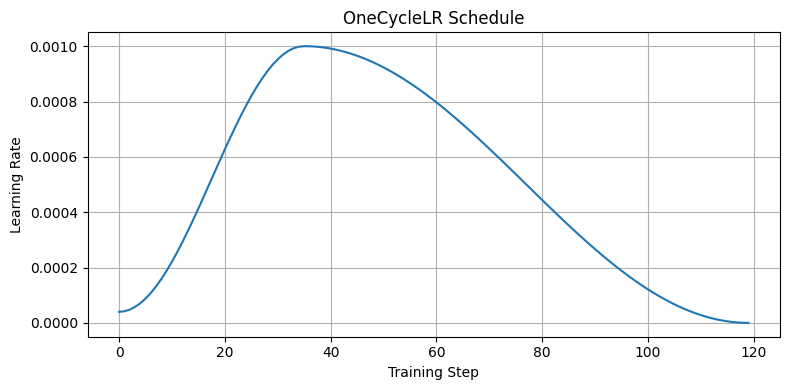

In [157]:
plt.figure(figsize=(8, 4))
plt.plot(lrs)
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.title("OneCycleLR Schedule")
plt.grid(True)
plt.tight_layout()
plt.savefig("lr-schedule.png")
plt.show()

In [103]:
best_model, best_acc = train_single_split(
    data_dir=loose_data_dir,
    model_name='efficientnet_b0',
    loss_fn=focal, # 'focal' or 'smooth'
    freeze_until=None,  # or 'features.4', None for no freezing. A higher layer means more layers are frozen.
    batch_size=32,
    lr=1e-4,
    num_epochs=20,
    val_split=0.2,
    num_classes=2
)

======= Single Split Training =======
Class sample counts: [34 66]


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold None, Epoch 1/20 - Train Loss: 0.4955, Train Acc: 0.3400 - Val Loss: 0.4061, Val Acc: 0.6000
Fold None, Epoch 2/20 - Train Loss: 0.4341, Train Acc: 0.5300 - Val Loss: 0.3819, Val Acc: 0.6000
Fold None, Epoch 3/20 - Train Loss: 0.3872, Train Acc: 0.6000 - Val Loss: 0.3477, Val Acc: 0.6400
Fold None, Epoch 4/20 - Train Loss: 0.3657, Train Acc: 0.6900 - Val Loss: 0.3014, Val Acc: 0.8000
Fold None, Epoch 5/20 - Train Loss: 0.3392, Train Acc: 0.6600 - Val Loss: 0.2633, Val Acc: 0.8800
Fold None, Epoch 6/20 - Train Loss: 0.2646, Train Acc: 0.7900 - Val Loss: 0.2159, Val Acc: 0.8400
Fold None, Epoch 7/20 - Train Loss: 0.2177, Train Acc: 0.8100 - Val Loss: 0.1763, Val Acc: 0.8000
Fold None, Epoch 8/20 - Train Loss: 0.1847, Train Acc: 0.8400 - Val Loss: 0.1495, Val Acc: 0.8400
Fold None, Epoch 9/20 - Train Loss: 0.1469, Train Acc: 0.8800 - Val Loss: 0.1251, Val Acc: 0.8800
Fold None, Epoch 10/20 - Train Loss: 0.0952, Train Acc: 0.9200 - Val Loss: 0.1109, Val Acc: 0.8800
Fold None, Epoch 11

## K-folds

In [24]:
kf_models_loose, accs_loose, recalls = run_kfold_training(
    data_dir=loose_data_dir,
    backbone='efficientnet_b0',  # or 'mobilenet_v3_small', 'efficientnet_b0', 'efficientnet_b3'
    loss_fn=smooth,
    freeze_until_layer=None,  # or 'features.4' for EfficientNet
    num_epochs=20,
    lr=1e-4,
    k_folds=5,
    batch_size=32,
    seed=42,
    num_classes=2,
    use_best_loss=False
)


======= Fold 1 =======
Class sample counts: [33 67]
Training set length: 100
Validation set length: 25


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.5600 and previous best 0.0000
Fold 1, Epoch 1/20 - Train Loss: 0.6805, Train Acc: 0.5700 - Val Loss: 0.6969, Val Acc: 0.5600
New best model found with accuracy 0.7600 and previous best 0.5600
Fold 1, Epoch 2/20 - Train Loss: 0.6497, Train Acc: 0.6100 - Val Loss: 0.6129, Val Acc: 0.7600
New best model found with accuracy 0.8800 and previous best 0.7600
Fold 1, Epoch 3/20 - Train Loss: 0.5690, Train Acc: 0.8300 - Val Loss: 0.4837, Val Acc: 0.8800
Fold 1, Epoch 4/20 - Train Loss: 0.4551, Train Acc: 0.8700 - Val Loss: 0.4643, Val Acc: 0.7600
Fold 1, Epoch 5/20 - Train Loss: 0.3467, Train Acc: 0.9100 - Val Loss: 0.6070, Val Acc: 0.7200
Fold 1, Epoch 6/20 - Train Loss: 0.3332, Train Acc: 0.9200 - Val Loss: 0.5659, Val Acc: 0.8400
Fold 1, Epoch 7/20 - Train Loss: 0.3457, Train Acc: 0.9100 - Val Loss: 0.5252, Val Acc: 0.8400
Fold 1, Epoch 8/20 - Train Loss: 0.4173, Train Acc: 0.9200 - Val Loss: 0.5553, Val Acc: 0.7600
Fold 1, Epoch 9/20 - Train Loss: 0.3155

/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.6400 and previous best 0.0000
Fold 2, Epoch 1/20 - Train Loss: 0.6972, Train Acc: 0.5800 - Val Loss: 0.6752, Val Acc: 0.6400
New best model found with accuracy 0.6800 and previous best 0.6400
Fold 2, Epoch 2/20 - Train Loss: 0.6384, Train Acc: 0.7100 - Val Loss: 0.6097, Val Acc: 0.6800
Fold 2, Epoch 3/20 - Train Loss: 0.5515, Train Acc: 0.8200 - Val Loss: 0.5782, Val Acc: 0.6400
New best model found with accuracy 0.7200 and previous best 0.6800
Fold 2, Epoch 4/20 - Train Loss: 0.3931, Train Acc: 0.9200 - Val Loss: 0.6606, Val Acc: 0.7200
Fold 2, Epoch 5/20 - Train Loss: 0.3305, Train Acc: 0.9300 - Val Loss: 0.7714, Val Acc: 0.7200
New best model found with accuracy 0.8000 and previous best 0.7200
Fold 2, Epoch 6/20 - Train Loss: 0.3407, Train Acc: 0.9100 - Val Loss: 0.6318, Val Acc: 0.8000
Fold 2, Epoch 7/20 - Train Loss: 0.2781, Train Acc: 0.9700 - Val Loss: 0.5189, Val Acc: 0.7600
New best model found with accuracy 0.8400 and previous best 0.8000


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.4000 and previous best 0.0000
Fold 3, Epoch 1/20 - Train Loss: 0.6880, Train Acc: 0.5100 - Val Loss: 0.7234, Val Acc: 0.4000
New best model found with accuracy 0.6800 and previous best 0.4000
Fold 3, Epoch 2/20 - Train Loss: 0.6371, Train Acc: 0.6600 - Val Loss: 0.6125, Val Acc: 0.6800
New best model found with accuracy 0.8400 and previous best 0.6800
Fold 3, Epoch 3/20 - Train Loss: 0.5703, Train Acc: 0.7800 - Val Loss: 0.4562, Val Acc: 0.8400
New best model found with accuracy 0.9200 and previous best 0.8400
Fold 3, Epoch 4/20 - Train Loss: 0.5201, Train Acc: 0.7300 - Val Loss: 0.3667, Val Acc: 0.9200
Fold 3, Epoch 5/20 - Train Loss: 0.3742, Train Acc: 0.9200 - Val Loss: 0.3208, Val Acc: 0.9200
New best model found with accuracy 0.9600 and previous best 0.9200
Fold 3, Epoch 6/20 - Train Loss: 0.3258, Train Acc: 0.9200 - Val Loss: 0.3089, Val Acc: 0.9600
Fold 3, Epoch 7/20 - Train Loss: 0.4186, Train Acc: 0.8800 - Val Loss: 0.4121, Val Acc: 0.8800


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.4800 and previous best 0.0000
Fold 4, Epoch 1/20 - Train Loss: 0.6919, Train Acc: 0.5100 - Val Loss: 0.7012, Val Acc: 0.4800
New best model found with accuracy 0.6000 and previous best 0.4800
Fold 4, Epoch 2/20 - Train Loss: 0.6384, Train Acc: 0.6700 - Val Loss: 0.6573, Val Acc: 0.6000
New best model found with accuracy 0.6400 and previous best 0.6000
Fold 4, Epoch 3/20 - Train Loss: 0.5650, Train Acc: 0.7500 - Val Loss: 0.5730, Val Acc: 0.6400
New best model found with accuracy 0.7200 and previous best 0.6400
Fold 4, Epoch 4/20 - Train Loss: 0.4681, Train Acc: 0.8500 - Val Loss: 0.5236, Val Acc: 0.7200
New best model found with accuracy 0.7600 and previous best 0.7200
Fold 4, Epoch 5/20 - Train Loss: 0.3837, Train Acc: 0.8900 - Val Loss: 0.5022, Val Acc: 0.7600
Fold 4, Epoch 6/20 - Train Loss: 0.3027, Train Acc: 0.9300 - Val Loss: 0.6556, Val Acc: 0.6400
Fold 4, Epoch 7/20 - Train Loss: 0.3323, Train Acc: 0.9300 - Val Loss: 0.8971, Val Acc: 0.6400


/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found with accuracy 0.6000 and previous best 0.0000
Fold 5, Epoch 1/20 - Train Loss: 0.6976, Train Acc: 0.4900 - Val Loss: 0.6660, Val Acc: 0.6000
New best model found with accuracy 0.7600 and previous best 0.6000
Fold 5, Epoch 2/20 - Train Loss: 0.6493, Train Acc: 0.6800 - Val Loss: 0.6021, Val Acc: 0.7600
Fold 5, Epoch 3/20 - Train Loss: 0.5979, Train Acc: 0.7200 - Val Loss: 0.5333, Val Acc: 0.7200
New best model found with accuracy 0.8000 and previous best 0.7600
Fold 5, Epoch 4/20 - Train Loss: 0.4651, Train Acc: 0.8800 - Val Loss: 0.4238, Val Acc: 0.8000
Fold 5, Epoch 5/20 - Train Loss: 0.4064, Train Acc: 0.8800 - Val Loss: 0.6309, Val Acc: 0.6800
New best model found with accuracy 0.8400 and previous best 0.8000
Fold 5, Epoch 6/20 - Train Loss: 0.3829, Train Acc: 0.8900 - Val Loss: 0.4243, Val Acc: 0.8400
New best model found with accuracy 0.9200 and previous best 0.8400
Fold 5, Epoch 7/20 - Train Loss: 0.2754, Train Acc: 0.9800 - Val Loss: 0.3190, Val Acc: 0.9200


In [34]:
subtype_accuracies['loose'] = 0.8959999999999999 #np.mean(accs)

## Save Model

In [ ]:
save_ensemble_to_onnx(kf_models_loose, accs_loose, output_path="loose_subtype_classification.onnx")

# Accuracy Computing

In [35]:
print("Consistency Recalls:", consistency_recalls)
print("Subtype Accuracies:", subtype_accuracies)

hierarchical_accuracy = compute_hierarchical_accuracy(
    consistency_recalls=consistency_recalls,
    subtype_accuracies=subtype_accuracies
)
print("Hierarchical Accuracy:", hierarchical_accuracy)

Consistency Recalls: {'constipated': 0.5875, 'normal': 0.8474769914312917, 'loose': 0.776}
Subtype Accuracies: {'constipated': 0.7830645161290324, 'normal': 0.7222997990056067, 'loose': 0.8959999999999999}
Hierarchical Accuracy: 0.5983340290221093


# Save Models